# A neural net with TensorFlow Core API

This is quick tryout for coding a neural network for machine learning using the Core API of TensorFlow. 

**Dataset:** I use the simple Iris dataset which consists of 150 examples of plants, each given with their 4 dimensions (which are used as input features) and its type (the output value that needs to be predicted). A plant can belong to one of three possible types. 

**Some info:** Three network architectures are compared: (4-5-3), (4-10-3) and (4-20-3), where 4 and 3 correspond to the input and output features, and the middle number denotes the nodes in one hidden layer. The tensorflow graph corresponds to the network architecture. The training phase runs in 2000 iterations using 120 examples, while the model evaluation is done on the rest 30 examples. I use a mean squared error as a loss function, and minimize it using the inbuilt gradient descent optimizer in tensorflow. Sigmoid is used for the activation function, and biases are not included (feel free to add bias nodes the models). The performance of the models is given through prediction accuracy towards the end of this notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import urllib.request as request

In [2]:
# Download dataset
IRIS_TRAIN_URL = "http://download.tensorflow.org/data/iris_training.csv"
IRIS_TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
train = pd.read_csv(IRIS_TRAIN_URL, names=names, skiprows=1)
test = pd.read_csv(IRIS_TEST_URL, names=names, skiprows=1)

# Train and test input data
Xtrain = train.drop("species", axis=1)
Xtest = test.drop("species", axis=1)

# Encode target values into binary ('one-hot' style) representation
ytrain = pd.get_dummies(train.species)
ytest = pd.get_dummies(test.species)

print(Xtrain.head(), Xtrain.shape)
print(Xtest.head(), Xtest.shape)
print(ytrain.head(), ytrain.shape)
print(ytest.head(), ytest.shape)

   sepal-length  sepal-width  petal-length  petal-width
0           6.4          2.8           5.6          2.2
1           5.0          2.3           3.3          1.0
2           4.9          2.5           4.5          1.7
3           4.9          3.1           1.5          0.1
4           5.7          3.8           1.7          0.3 (120, 4)
   sepal-length  sepal-width  petal-length  petal-width
0           5.9          3.0           4.2          1.5
1           6.9          3.1           5.4          2.1
2           5.1          3.3           1.7          0.5
3           6.0          3.4           4.5          1.6
4           5.5          2.5           4.0          1.3 (30, 4)
   0  1  2
0  0  0  1
1  0  1  0
2  0  0  1
3  1  0  0
4  1  0  0 (120, 3)
   0  1  2
0  0  1  0
1  0  0  1
2  1  0  0
3  0  1  0
4  0  1  0 (30, 3)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Reset the graph
tf.reset_default_graph()
    
def train(hidden_nodes, num_iters):
    """ Build a tensorflow model of a neural network """

    # Placeholders for input and output data
    X = tf.placeholder(shape=(120, 4), dtype=tf.float64, name='X')
    y = tf.placeholder(shape=(120, 3), dtype=tf.float64, name='y')

    # Variables for two group of weights between the three layers of the network
    W1 = tf.Variable(np.random.rand(4, hidden_nodes), dtype=tf.float64)
    W2 = tf.Variable(np.random.rand(hidden_nodes, 3), dtype=tf.float64)

    # Create the neural net graph
    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))

    # Define a loss function
    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)

    # Define a train operation to minimize the loss
    optimizer = tf.train.GradientDescentOptimizer(0.005)
    train = optimizer.minimize(loss)

    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Go through 100 iterations
    for i in range(num_iters):
        sess.run(train, feed_dict={X: Xtrain, y: ytrain})
        loss_plot[hidden_nodes].append(sess.run(loss, feed_dict={X: Xtrain.as_matrix(), y: ytrain.as_matrix()}))
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)
        
        # todo: print loss

    sess.close()
    return weights1, weights2

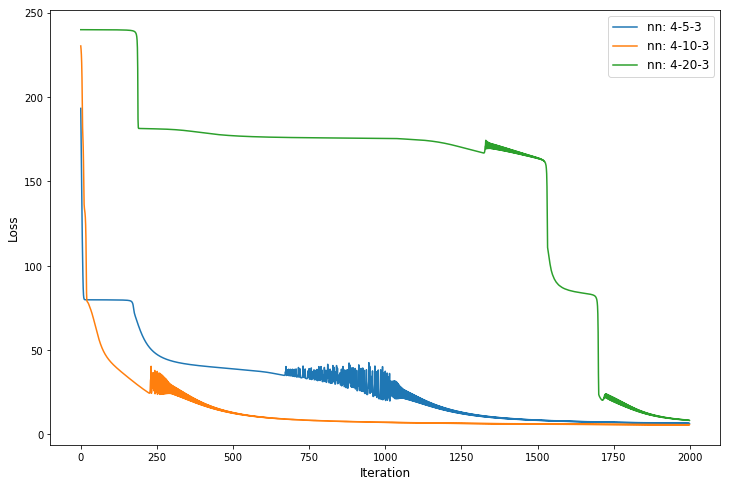

In [68]:
# Run the training for 3 different network architectures: (4-5-3) (4-10-3) (4-20-3)
# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20: []}
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
num_iters = 2000

plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = train(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 4-%d-3" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

In [69]:
# Evaluate models on the test set
X = tf.placeholder(shape=(30, 4), dtype=tf.float64, name='X')
y = tf.placeholder(shape=(30, 3), dtype=tf.float64, name='y')

for hidden_nodes in num_hidden_nodes:

    # Forward propagation
    W1 = tf.Variable(weights1[hidden_nodes])
    W2 = tf.Variable(weights2[hidden_nodes])
    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        y_est_np = sess.run(y_est, feed_dict={X: Xtest, y: ytest})

    correct = [estimate.argmax(axis=0) == target.argmax(axis=0) 
               for estimate, target in zip(y_est_np, ytest.as_matrix())]
    accuracy = 100 * sum(correct) / len(correct)
    print('Network architecture 4-%d-3, accuracy: %.2f%%' % (hidden_nodes, accuracy))

Network architecture 4-5-3, accuracy: 93.33%
Network architecture 4-10-3, accuracy: 96.67%
Network architecture 4-20-3, accuracy: 96.67%
